In [ ]:
# !pip install --upgrade pip
!pip install --user -r requirements.txt

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb

In [4]:
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay, auc, roc_curve)

# Extract Data

Data Extraction and first Data Exploration

In [6]:
df = pd.read_csv('Dataset/Airlines.csv')

In [7]:
df.isnull().sum()

id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

In [8]:
df.dtypes

id              int64
Airline        object
Flight          int64
AirportFrom    object
AirportTo      object
DayOfWeek       int64
Time            int64
Length          int64
Delay           int64
dtype: object

In [9]:
cols = df.columns
for i in range(0,len(cols)):
    print(df[cols[i]].value_counts(),'\n')
    print('********************************************\n')

1         1
359600    1
359598    1
359597    1
359596    1
         ..
179791    1
179790    1
179789    1
179788    1
539383    1
Name: id, Length: 539383, dtype: int64 

********************************************

WN    94097
DL    60940
OO    50254
AA    45656
MQ    36605
US    34500
XE    31126
EV    27983
UA    27619
CO    21118
FL    20827
9E    20686
B6    18112
YV    13725
OH    12630
AS    11471
F9     6456
HA     5578
Name: Airline, dtype: int64 

********************************************

16      420
5       407
9       401
8       396
62      364
       ... 
7814      1
3573      1
4385      1
3292      1
6969      1
Name: Flight, Length: 6585, dtype: int64 

********************************************

ATL    34449
ORD    24822
DFW    22154
DEN    19843
LAX    16657
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportFrom, Length: 293, dtype: int64 

********************************************

ATL    34440
ORD    24871
DFW   

# Feature Extraction

Given the Initial Data some derived feature can be extracted:

*   We can transform the time and length of the flights from minutes to hours.
*   We can derive the time of the day in which the flight was taken
*   We can determine if a flight was taken in a holiday period or not
*   Consequently given the duration of the flight we can get the Arrival time and period of the flight.

In [10]:
df['Length_by_hours'] = df['Length'] / 60
df['Time_by_hour'] = df['Time'] / 60

In [11]:
#0 --> Morning | 1 --> Afternoon | 2 --> Evening | 3 --> Night
departure_period = []
for i in range(0,len(df)):
    if ((df['Time_by_hour'][i] >= 5) & (df['Time_by_hour'][i] < 12)):      
        departure_period.append(0)
    elif ((df['Time_by_hour'][i] >= 12) & (df['Time_by_hour'][i] < 17)):    
        departure_period.append(1)
    elif ((df['Time_by_hour'][i] >= 17) & (df['Time_by_hour'][i] < 21)): 
        departure_period.append(2)
    else: 
        departure_period.append(3)

df['Departure_period'] = departure_period

In [12]:
df['Departure_period'].value_counts()

0    223289
1    170239
2    120044
3     25811
Name: Departure_period, dtype: int64

In [13]:
# 0 --> not holiday | 1 --> holiday
holiday = []
for i in range(0,len(df)):
    if ((df['DayOfWeek'][i] == 6) | (df['DayOfWeek'][i] == 7)):      
        holiday.append(1)
    else: 
        holiday.append(0)

df['Holiday'] = holiday

In [14]:
df['Holiday'].value_counts()

0    410548
1    128835
Name: Holiday, dtype: int64

In [15]:
arrival_time = []
for i in range(0,len(df)):     
    if ((df['Time_by_hour'][i] + df['Length_by_hours'][i]) >=24):
        arrival_time.append((df['Time_by_hour'][i] + df['Length_by_hours'][i])-24)
    else:
        arrival_time.append(df['Time_by_hour'][i] + df['Length_by_hours'][i])
        
df['Arrival_Time'] = arrival_time

In [16]:
arrival_period = []
for i in range(0,len(df)):
    if ((df['Arrival_Time'][i] >= 5) & (df['Arrival_Time'][i] < 12)):      
        arrival_period.append(0)
    elif ((df['Arrival_Time'][i] >= 12) & (df['Arrival_Time'][i] < 17)):    
        arrival_period.append(1)
    elif ((df['Arrival_Time'][i] >= 17) & (df['Arrival_Time'][i] < 21)): 
        arrival_period.append(2)
    else: 
        arrival_period.append(3)
        
df['Arrival_period'] = arrival_period

In [17]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Length_by_hours,Time_by_hour,Departure_period,Holiday,Arrival_Time,Arrival_period
0,1,CO,269,SFO,IAH,3,15,205,1,3.416667,0.250000,3,0,3.666667,3
1,2,US,1558,PHX,CLT,3,15,222,1,3.700000,0.250000,3,0,3.950000,3
2,3,AA,2400,LAX,DFW,3,20,165,1,2.750000,0.333333,3,0,3.083333,3
3,4,AA,2466,SFO,DFW,3,20,195,1,3.250000,0.333333,3,0,3.583333,3
4,5,AS,108,ANC,SEA,3,30,202,0,3.366667,0.500000,3,0,3.866667,3


# Data Analysis

Some Graphical Informations About the Data Generated

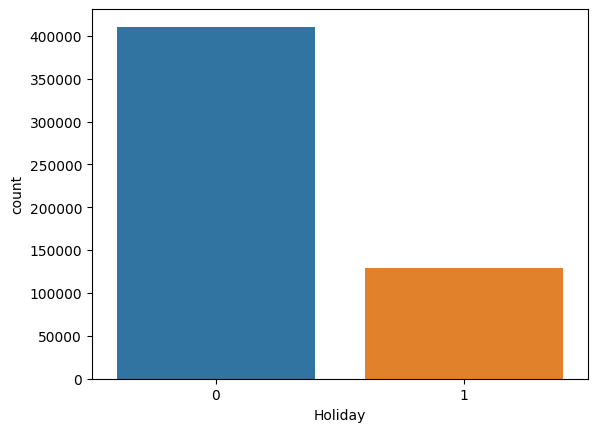

In [18]:
sns.countplot(x=df['Holiday'])

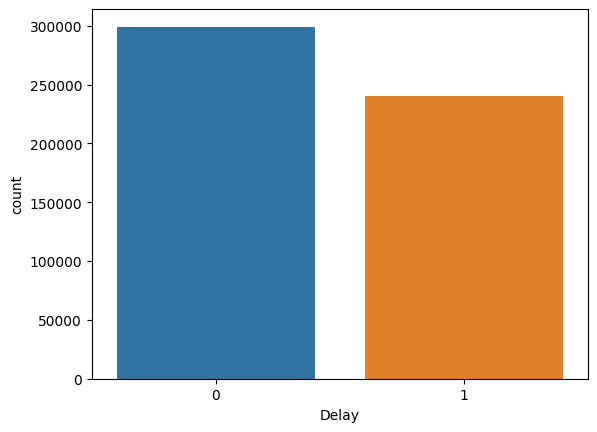

In [19]:
sns.countplot(x=df['Delay'])

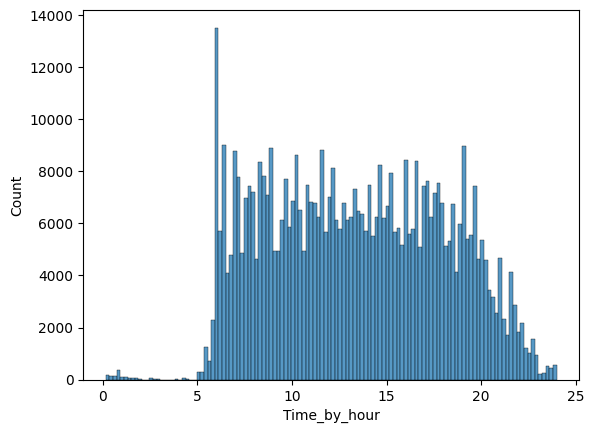

In [20]:
sns.histplot(df['Time_by_hour'])

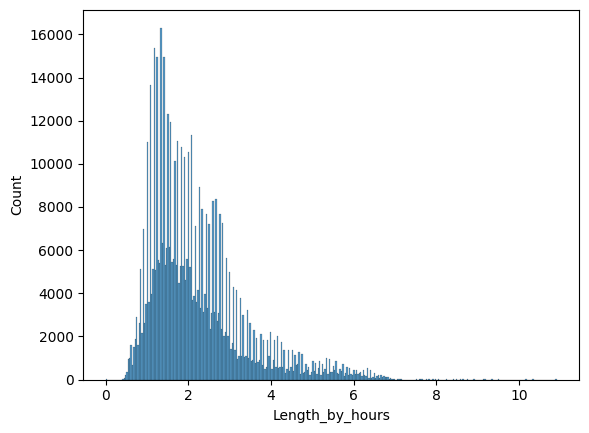

In [21]:
sns.histplot(df['Length_by_hours'])

# Clean Data

Remove columns not used for the Prediction 

In [22]:
df.drop(columns=['Length', 'Time'], inplace=True)

In [23]:
df.drop(columns=['id'], inplace=True)

# Correlation among features

Show the correlation among the features

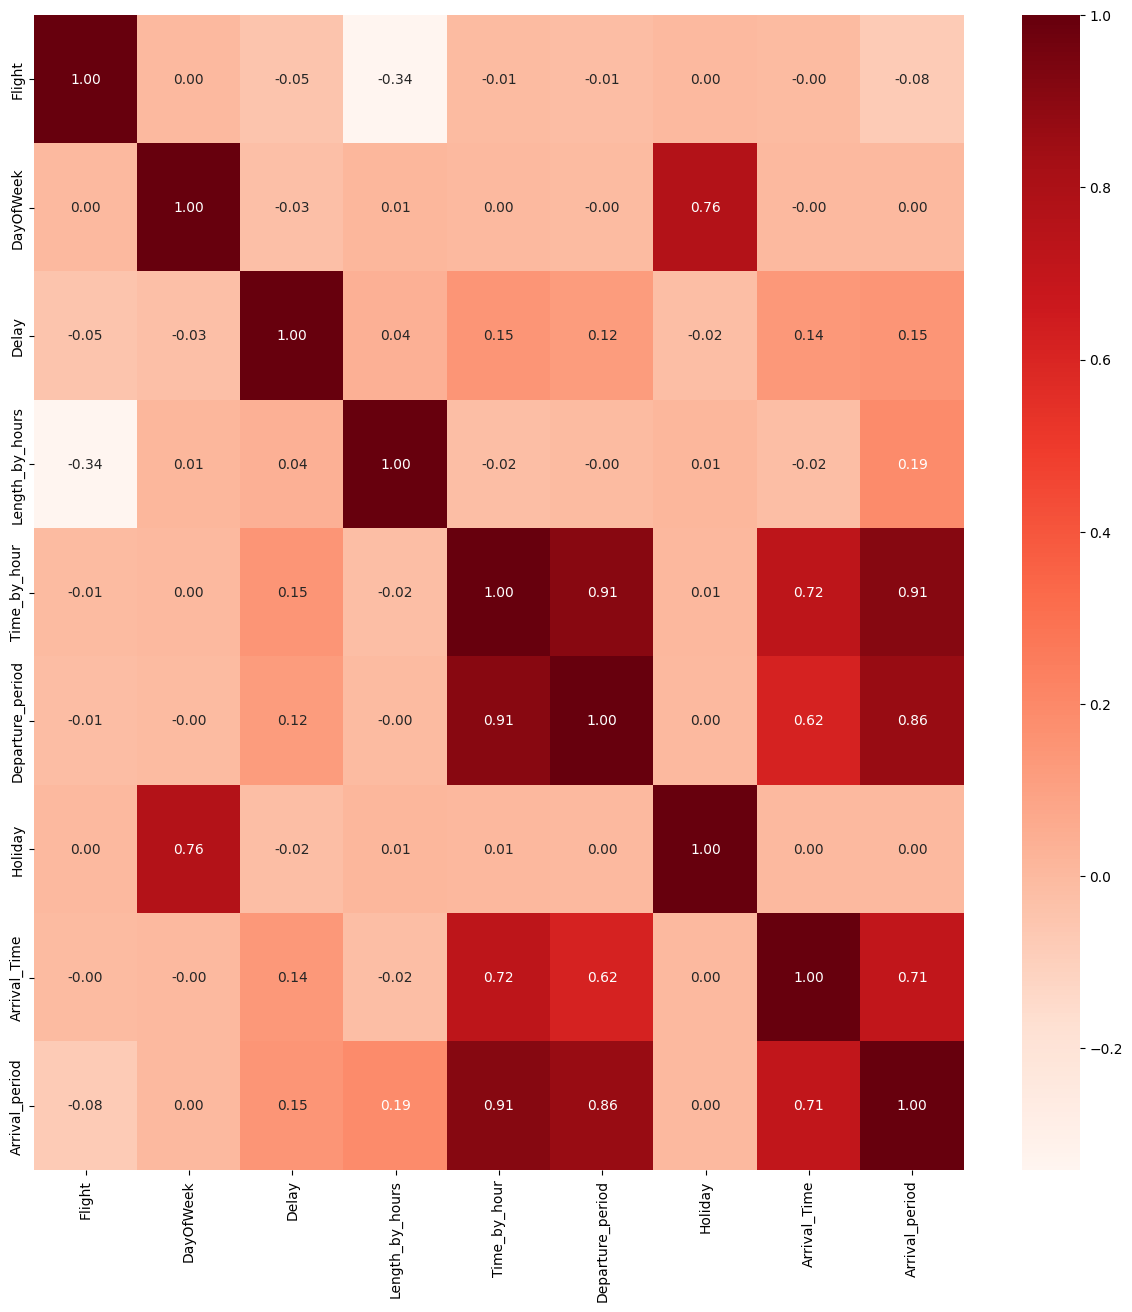

In [24]:
plt.figure(figsize=(15,15))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

# Transform Data

Because the dataset contains some categorical data as the AirportFrom and AirportTo fields we have to convert them in numerical form. This can be done with a LabelEncoder.

In [25]:
le = preprocessing.LabelEncoder()

In [26]:
airportfrom = dict()
tmp = le.fit_transform(df['AirportFrom'])
for x, y in zip(df['AirportFrom'], tmp):
  airportfrom[x] = y
df['AirportFrom'] = tmp 

In [27]:
airlines = dict()
tmp = le.fit_transform(df['Airline'])
for x, y in zip(df['Airline'], tmp):
  airlines[x] = y
df['Airline'] = tmp 

In [28]:
airportto = dict()
tmp = le.fit_transform(df['AirportTo'])
for x, y in zip(df['AirportTo'], tmp):
  airportto[x] = y
df['AirportTo'] = tmp 

# Save Inverse Dictionary

In [29]:
def save_model(model, path):
    joblib.dump(model, open(path,'wb'))

In [30]:
inverse_dict = {'airlines': airlines,
                'airportfrom': airportfrom,
                'airportto': airportto}

save_model(inverse_dict, 'inverse.sav')

# Train Test Split

Split the dataset in Train and Test where:


*   Training set contains 80% of the original data splitted between a training set and a Validation set, with a 80-20 split.
*   Test Set contains 20% of the data and is used for the final model evaluation.



In [31]:
X = df.drop(columns='Delay')
y = df['Delay']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True,
                                                    stratify=y, random_state=66)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, shuffle=True,
                                                  stratify=y_train, random_state=66)

# Train Model

In [34]:
def score_model(yt, yp):
    accuracy = round(accuracy_score(yt, yp), 3)
    precision = round(precision_score(yt, yp), 3)
    recall = round(recall_score(yt, yp), 3)
    return accuracy, precision, recall;

def output_result(accuracy, precision, recall):
    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    
def plot_conf_matrix(yt, yp):
    CM_DT = confusion_matrix(yt, yp, normalize='true')
    sns.heatmap(CM_DT, annot=True, center=True)
    plt.show()
    
def print_score(name, model, X, y, Xv, yv):
    print(name,' Train Score is : ' , model.score(X, y))
    print(name, ' Validation Score is : ' , model.score(Xv, yv))
    
def print_roc(y_pred, y_test):
    fpr, tpr, thresholds =roc_curve(y_pred, y_test)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                              estimator_name='example estimator')
    display.plot()
    plt.show()
    
def compute_weights(y):
    one =  y.value_counts()[1]
    zero = y.value_counts()[0]
    summ = one + zero
    return {0: zero/summ, 1: one/summ}

## Train XGB

In [35]:
d = compute_weights(y); p= d[0]; n= d[1];

XGBClassifier = xgb.XGBClassifier(max_leaves = 500, n_estimators=50, max_depth=12, learning_rate=0.01,
                                 random_state=66, scale_pos_weight=n/p, n_jobs = 6)

XGBClassifier.fit(X_train, y_train)

print_score('XGBClassifier', XGBClassifier, X_train, y_train, X_val, y_val)

XGBClassifier  Train Score is :  0.6776311977844984
XGBClassifier  Validation Score is :  0.65106254779727


## Test XGB

Accuracy of the model: 0.651
Precision Score of the model: 0.695
Recall Score of the model: 0.387


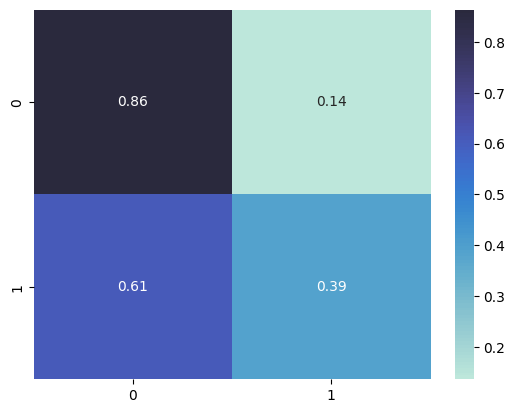

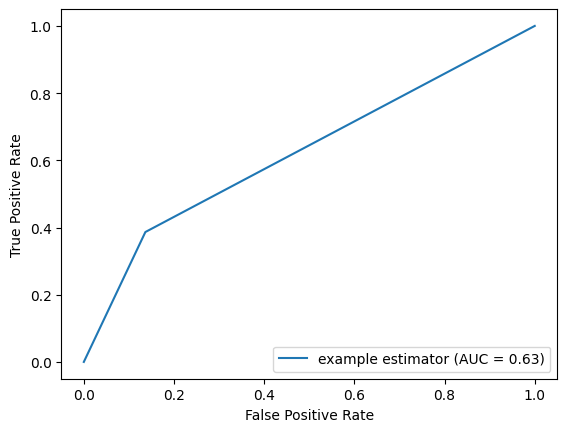

In [36]:
y_pred_XGB = XGBClassifier.predict(X_val)

accuracy, precision, recall = score_model(y_val, y_pred_XGB)
output_result(accuracy, precision, recall)
plot_conf_matrix(y_val, y_pred_XGB)
print_roc(y_val, y_pred_XGB)

## Save XGB

In [37]:
save_model(XGBClassifier,"XGBClassifier.sav")

## Train Random Forest

In [38]:
RandomForestClassifierModel = RandomForestClassifier(criterion = 'gini', max_depth=20, n_estimators=50,
                                                     max_features='log2', random_state=66,
                                                     class_weight = compute_weights(y))
RandomForestClassifierModel.fit(X_train, y_train)

print_score('RandomForestClassifierModel', RandomForestClassifierModel, X_train, y_train, X_val, y_val)

RandomForestClassifierModel  Train Score is :  0.7990347736410934
RandomForestClassifierModel  Validation Score is :  0.6446664040230817


## Test Random Forest

Accuracy of the model: 0.645
Precision Score of the model: 0.631
Recall Score of the model: 0.487


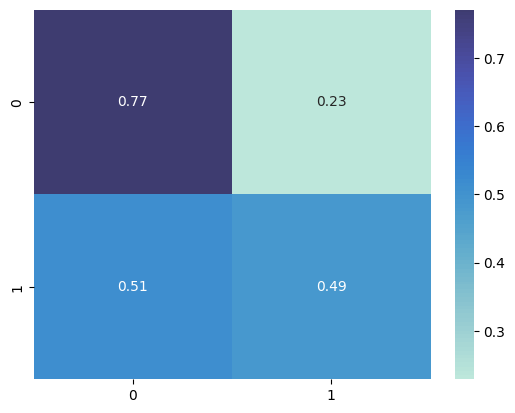

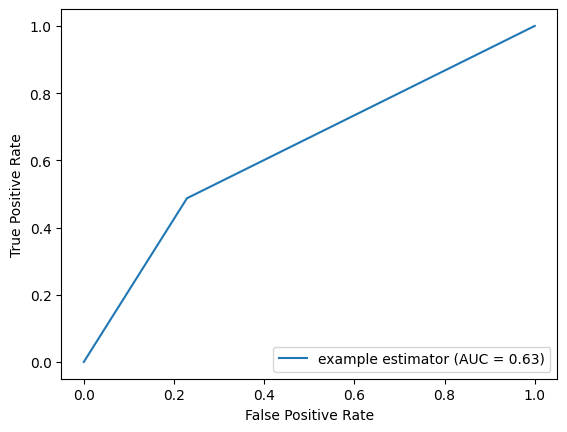

In [39]:
y_pred_RF = RandomForestClassifierModel.predict(X_val)

accuracy, precision, recall = score_model(y_val, y_pred_RF)
output_result(accuracy, precision, recall)
plot_conf_matrix(y_val, y_pred_RF)
print_roc(y_val, y_pred_RF)

## Save Random Forest

In [40]:
save_model(RandomForestClassifierModel, "RandomForest.sav")

## Train KNeighborsClassifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier

KNeighborsClassifier = KNeighborsClassifier()
KNeighborsClassifier.fit(X_train, y_train)

print_score('KNeighborsClassifier', KNeighborsClassifier, X_train, y_train, X_val, y_val)

KNeighborsClassifier  Train Score is :  0.7542467642321642
KNeighborsClassifier  Validation Score is :  0.6341220365692568


## Test KNeighborsClassifier

Accuracy of the model: 0.634
Precision Score of the model: 0.598
Recall Score of the model: 0.546


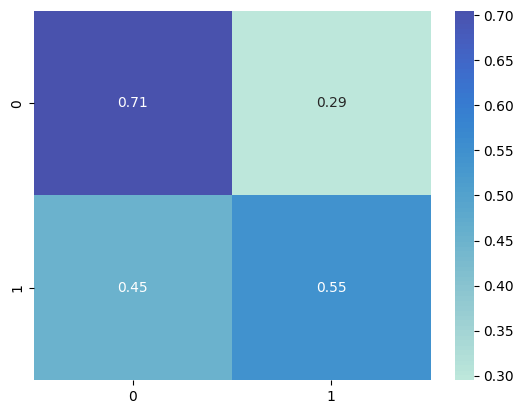

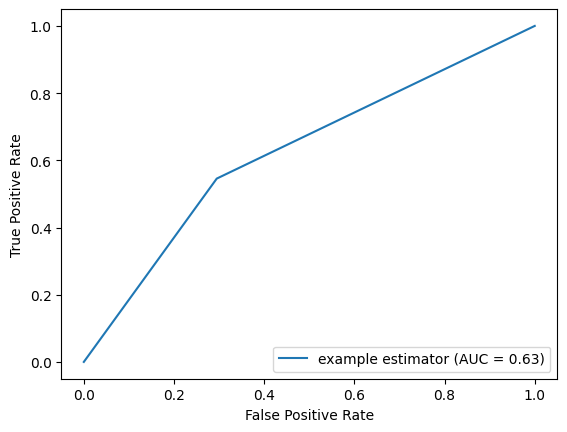

In [42]:
y_pred_KN = KNeighborsClassifier.predict(X_val)

accuracy, precision, recall = score_model(y_val, y_pred_KN)
output_result(accuracy, precision, recall)
plot_conf_matrix(y_val, y_pred_KN)
print_roc(y_val, y_pred_KN)

## Save KNeighborsClassifier

In [43]:
save_model(KNeighborsClassifier, "KNeighborsClassifier.sav")

## Train ensamble

In [ ]:
VotingClassifierModel = VotingClassifier(estimators=[('KNeighborsClassifier',KNeighborsClassifier),
                                                     ('RFCModel',RandomForestClassifierModel),
                                                     ('XGB',XGBClassifier)],
                                         voting='hard')

VotingClassifierModel.fit(X_train, y_train)

print_score('VotingClassifierModel', VotingClassifierModel, X_train, y_train, X_val, y_val)

## Test Ensamble

In [ ]:
y_pred_V = VotingClassifierModel.predict(X_val)

accuracy, precision, recall = score_model(y_val, y_pred_V)
output_result(accuracy, precision, recall)
plot_conf_matrix(y_val, y_pred_V)
print_roc(y_val, y_pred_V)

# Model Evaluation

In [ ]:
y_pred_V = VotingClassifierModel.predict(X_test)

accuracy, precision, recall = score_model(y_test, y_pred_V)
output_result(accuracy, precision, recall)
plot_conf_matrix(y_test, y_pred_V)
print_roc(y_test, y_pred_V)

# Save Ensamble

In [ ]:
save_model(VotingClassifierModel, "VotingClassifier.sav")